## CODE
#### Imports


In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import MyUtils
from importlib import reload
import UNet
import pickle

#### User Input Data


In [20]:
path_images = "D:\\Work\\Sarbazi\\data\\dataset"
path_masks = "D:\\Work\\Sarbazi\\data\\dataset\\manual segmentation"
batch_size = 4
image_shape = (320, 160)

#### Data Generation


In [21]:
MyUtils = reload(MyUtils)
id_all_data = MyUtils.get_id_all_data(path_masks)
id_training_data, id_testing_data = MyUtils.split_train_test_id(id_all_data,testing_share=0.2)
training_data = MyUtils.DataGenerator(path_images, path_masks, id_training_data, batch_size, image_shape)
testing_data = MyUtils.DataGenerator(path_images, path_masks, id_testing_data, 20, image_shape, shuffle=False)

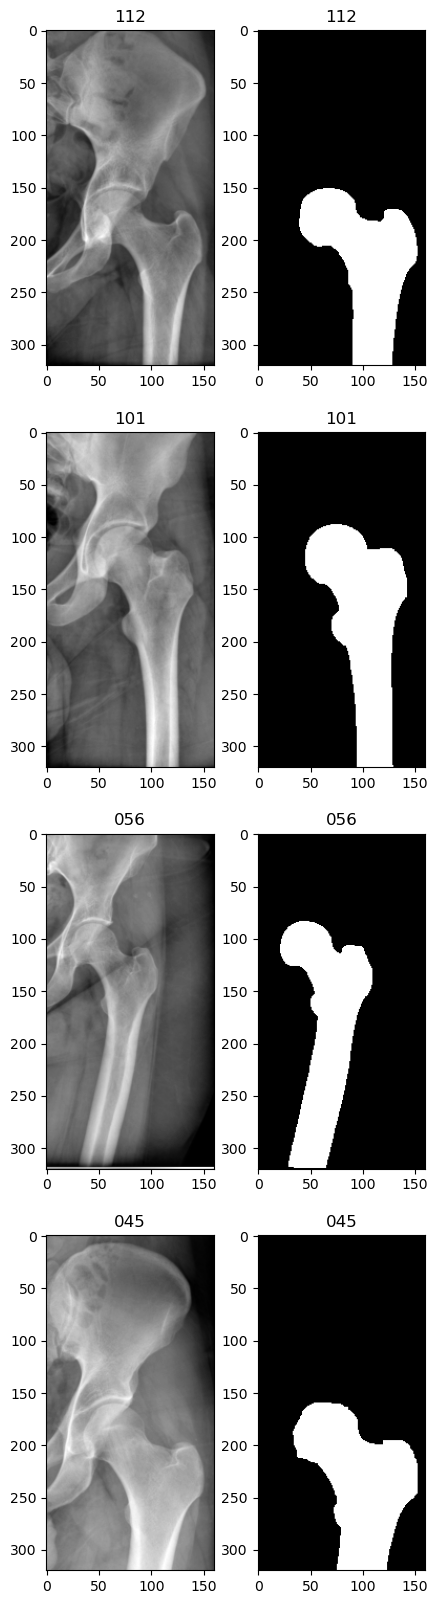

In [22]:
batch_id = 0
sample_batch_image, sample_batch_mask = training_data.__getitem__(batch_id)
img_ids = training_data._get_image_ids(batch_id)
fig, ax = plt.subplots(4, 2, figsize=(5, 20))
for i in range(batch_size):
    ax[i, 0].imshow(sample_batch_image[i,:,:,0],cmap='gray')
    ax[i, 0].set_title(str(img_ids[i]).zfill(3))
    ax[i, 1].imshow(sample_batch_mask[i,:,:,0],cmap='gray')
    ax[i, 1].set_title(str(img_ids[i]).zfill(3))

#### Create U-Net


In [5]:
UNet = reload(UNet)
MyUtils = reload(MyUtils)
UNetModel = UNet.create_UNet((None,None,1), (None,None,1))
UNetModel.compile(optimizer="adam", loss="binary_crossentropy", metrics=["acc"])
# UNetModel.compile(optimizer="adam", loss=MyUtils.dice_coef_loss, metrics=[MyUtils.dice_coef])
UNetModel.summary(line_length=120)

Model: "model"
________________________________________________________________________________________________________________________
 Layer (type)                          Output Shape               Param #       Connected to                            
 input_1 (InputLayer)                  [(None, None, None, 1)]    0             []                                      
                                                                                                                        
 conv2d (Conv2D)                       (None, None, None, 4)      40            ['input_1[0][0]']                       
                                                                                                                        
 conv2d_1 (Conv2D)                     (None, None, None, 4)      148           ['conv2d[0][0]']                        
                                                                                                                        
 max_pooling2d (M

In [10]:
UNetModel.fit(training_data, validation_data=testing_data, epochs=50, workers=10)

Epoch 1/50
20/20 [==============================] - 15s 639ms/step - loss: 0.0921 - acc: 0.9900 - val_loss: 0.0975 - val_acc: 0.9822
Epoch 2/50
20/20 [==============================] - 11s 434ms/step - loss: 0.0377 - acc: 0.9886 - val_loss: 0.0535 - val_acc: 0.9818
Epoch 3/50
20/20 [==============================] - 11s 452ms/step - loss: 0.1133 - acc: 0.9625 - val_loss: 0.1632 - val_acc: 0.9624
Epoch 4/50
20/20 [==============================] - 11s 450ms/step - loss: 0.1590 - acc: 0.9484 - val_loss: 0.1012 - val_acc: 0.9632
Epoch 5/50
20/20 [==============================] - 10s 443ms/step - loss: 0.1280 - acc: 0.9582 - val_loss: 0.0819 - val_acc: 0.9679
Epoch 6/50
20/20 [==============================] - 11s 464ms/step - loss: 0.0835 - acc: 0.9688 - val_loss: 0.0974 - val_acc: 0.9665
Epoch 7/50
20/20 [==============================] - 11s 448ms/step - loss: 0.0602 - acc: 0.9762 - val_loss: 0.0635 - val_acc: 0.9762
Epoch 8/50
20/20 [==============================] - 11s 491ms/step - 

In [11]:
UNetModel.save_weights('UNetModel_weights.h5')

In [6]:
UNetModel.load_weights('UNetModel_weights.h5')

In [18]:
batch_id = 0
sample_test_image, sample_test_mask = testing_data.__getitem__(batch_id)
predict_segment = UNetModel.predict(sample_test_image)
predict_segment = (predict_segment>0.5).astype(np.bool_)

1/1 [==============================] - 2s 2s/step


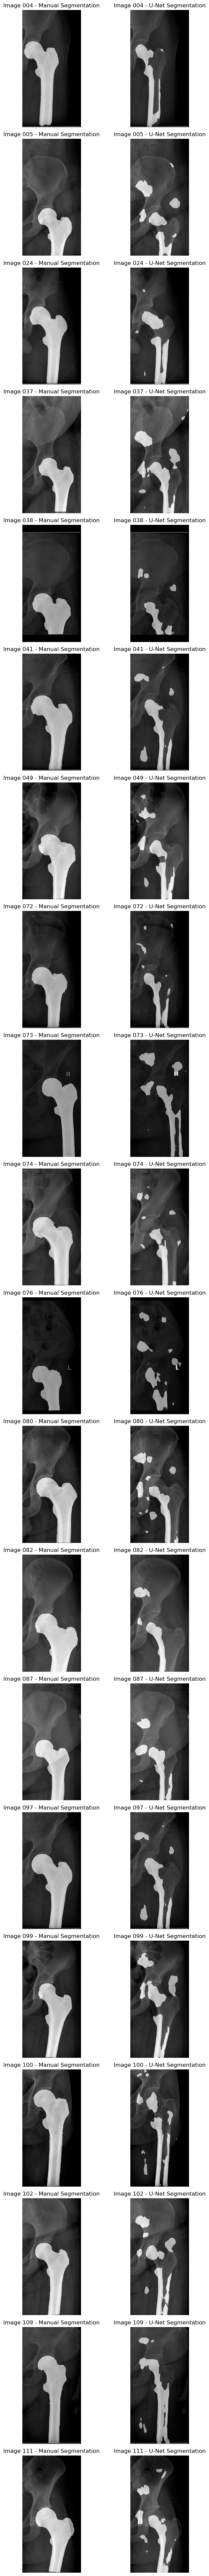

In [19]:
fig, axs = plt.subplots(sample_test_image.shape[0], 2, figsize=(8,100))
titles = [str(i).zfill(3) for i in testing_data._get_image_ids(batch_id)]
for i in range(sample_test_image.shape[0]):
    axs[i,0].imshow(sample_test_image[i,:,:,0], cmap='gray')
    axs[i,0].imshow(sample_test_mask[i,:,:,0],cmap='gray',alpha=0.5)
    axs[i,0].set_title("Image %s - Manual Segmentation" % (titles[i]))
    axs[i,0].axis('off')
    axs[i,1].imshow(sample_test_image[i,:,:,0], cmap='gray')
    axs[i,1].imshow(predict_segment[i,:,:,0],cmap='gray',alpha=0.5)
    axs[i,1].set_title("Image %s - U-Net Segmentation" % (titles[i]))
    axs[i,1].axis('off')
plt.subplots_adjust(hspace=0.1, wspace=0.1)

In [36]:
with open('out.png','wb') as f:
    fig.savefig(f, dpi=600)